In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import time
import os

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# Image preprocessing modules
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])

train_transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor(),
    normalize])
    
test_transform = transforms.Compose([
    transforms.ToTensor(),
    normalize])

train_dataset = torchvision.datasets.CIFAR10(root='data/',train=True, transform=train_transform,download=True)
test_dataset = torchvision.datasets.CIFAR10(root='data/',train=False, transform=test_transform)

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=64, shuffle=False)


Extracting data/cifar-10-python.tar.gz to data/


In [4]:
def conv3x3(in_channels, out_channels, stride=1):
    """
    return 3x3 Conv2d
    """
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,stride=stride, padding=1, bias=False)


class ResidualBlock(nn.Module):
    """
    Initialize basic ResidualBlock with forward propogation
    """
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out


class ResNet(nn.Module):
    """
    Initialize  ResNet with forward propogation
    """
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [5]:
model = ResNet(ResidualBlock, [3, 3, 3]).to(device)
model.eval();

In [6]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# For updating learning rate
def update_lr(optimizer, lr):
    """
    This method update learning rate
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.001

In [8]:
def evaluate(model):
    """
    Evaluate accuracy of test set and save weight of model
    """
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

In [9]:
# Train the model
def train(train_loader, test_loader, num_epochs=200):
    total_step = len(train_loader)
    curr_lr = 0.001
    accuracies = []
    for epoch in range(num_epochs):
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in test_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
            accuracy = 100*correct/total
            accuracies.append(accuracy)
            print('Accuracy of the model on the test images: {} %'.format(accuracy))
        
        # Decay learning rate
        if epoch % 30 == 0:
            curr_lr /= 4
            update_lr(optimizer, curr_lr)

    return accuracies

In [10]:
accuracies = train(train_loader, test_loader)

Accuracy of the model on the test images: 47.21 %
Accuracy of the model on the test images: 55.8 %
Accuracy of the model on the test images: 58.92 %
Accuracy of the model on the test images: 61.09 %
Accuracy of the model on the test images: 62.59 %
Accuracy of the model on the test images: 65.15 %
Accuracy of the model on the test images: 65.94 %
Accuracy of the model on the test images: 68.26 %
Accuracy of the model on the test images: 69.74 %
Accuracy of the model on the test images: 70.72 %
Accuracy of the model on the test images: 71.08 %
Accuracy of the model on the test images: 73.21 %
Accuracy of the model on the test images: 73.53 %
Accuracy of the model on the test images: 73.66 %
Accuracy of the model on the test images: 75.44 %
Accuracy of the model on the test images: 74.95 %
Accuracy of the model on the test images: 76.07 %
Accuracy of the model on the test images: 77.25 %
Accuracy of the model on the test images: 78.31 %
Accuracy of the model on the test images: 76.87 %
A

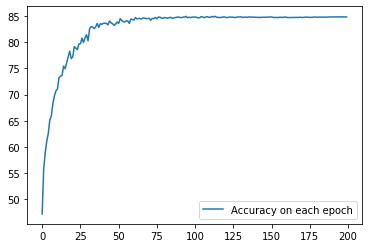

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(accuracies)), accuracies, label = 'Accuracy on each epoch')
plt.legend()

In [20]:
torch.save(model.state_dict(), 'trained_model.pt')